## Assignment #3
David Perry - sez326

Chapter 4 

Applied Exercises 13, 14, & 16

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML


## 13. 
This question is to be answered using the 'Weekly' data set, which is part of the ISLR package. This data is similar in nature to the 'Smarket' data from Chapter 4’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [236]:
# Load data
from ISLP import load_data

weekly_df = load_data("weekly")

# Check for missing data
assert weekly_df.isnull().sum().sum() == 0

# Pre-processing
weekly_df = pd.get_dummies(weekly_df).drop('Direction_Down', axis=1)
weekly_df


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,1
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,1
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,1
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,1


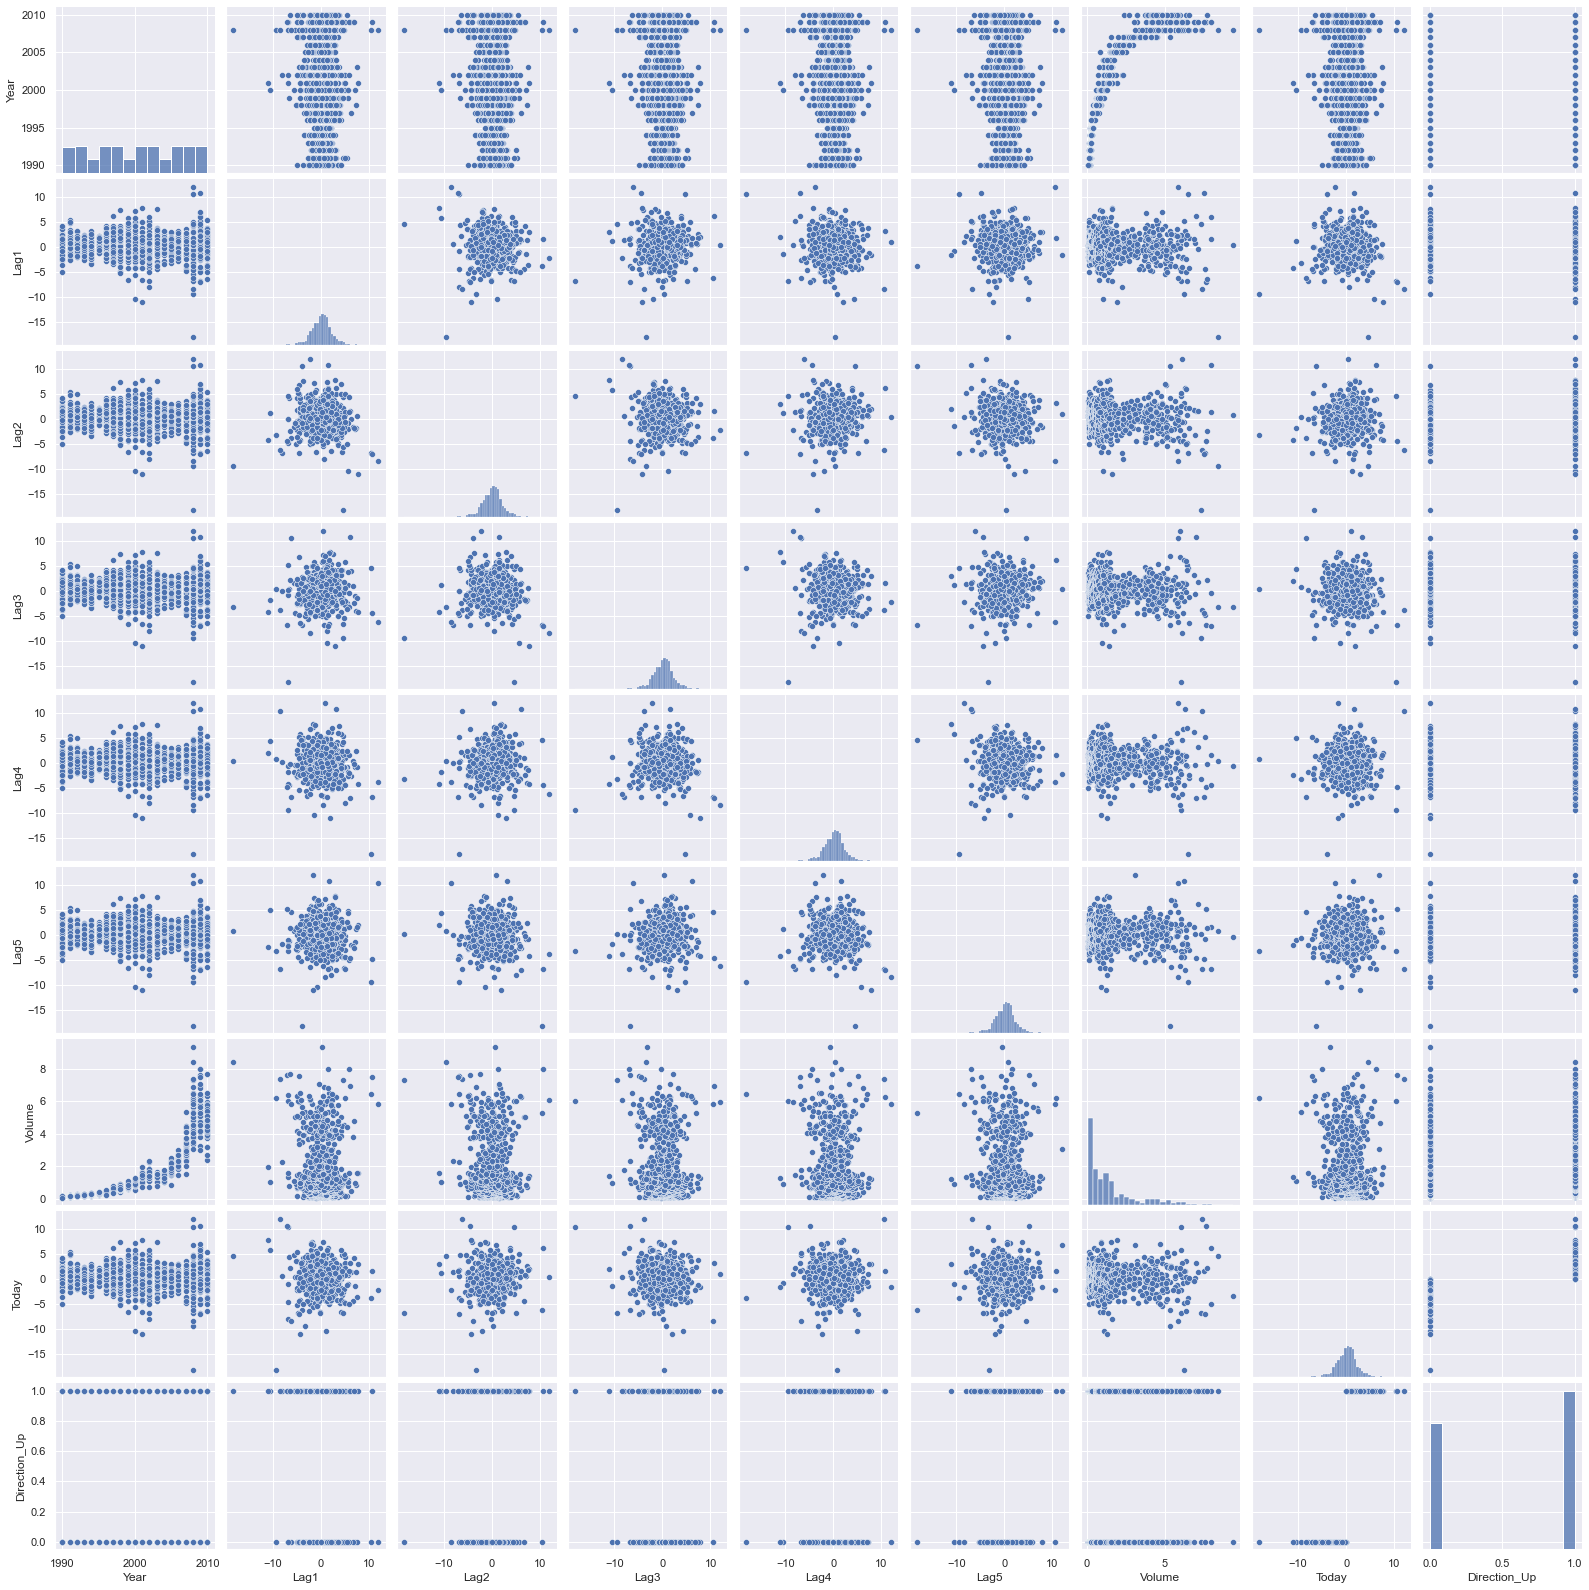

In [237]:
# Pairplot
sns.pairplot(weekly_df);

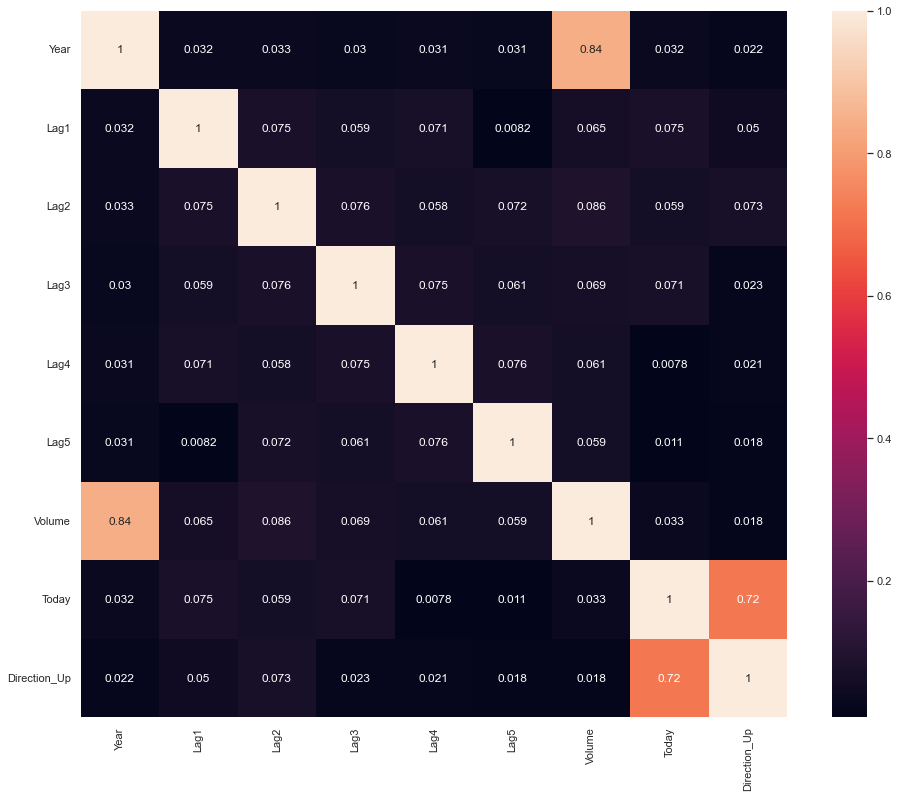

In [238]:
# Correlation matrix
corr_matrix = weekly_df.corr().abs()
fig, ax     = plt.subplots(figsize=(16, 13))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

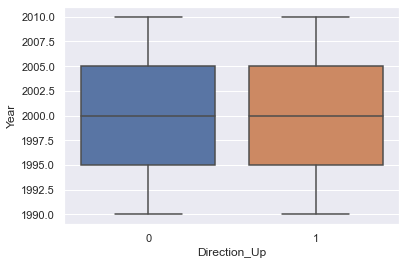

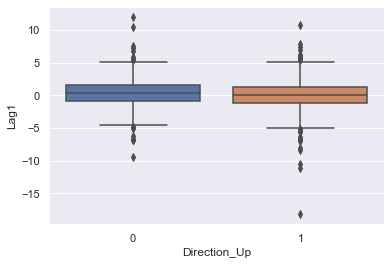

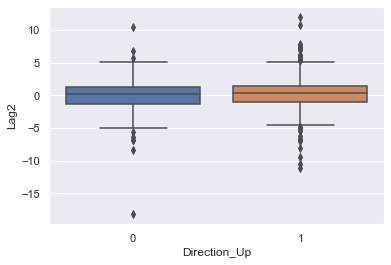

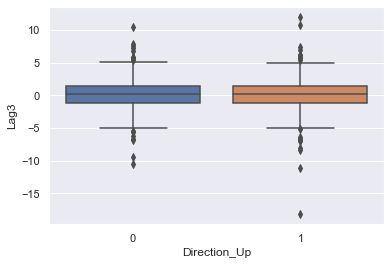

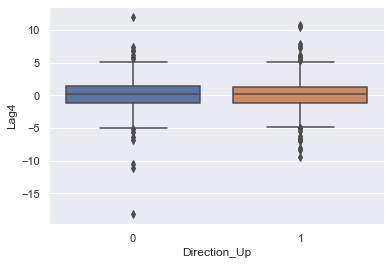

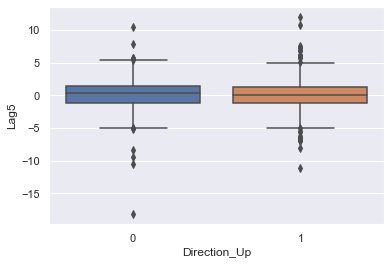

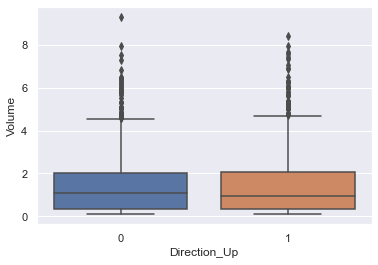

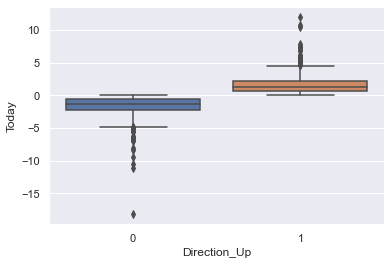

In [239]:
for col in weekly_df.columns:
    if col != 'Direction_Up':
        sns.boxplot(y = col,x = 'Direction_Up', data = weekly_df)
        plt.show()

Looking at the pairplot above suggests the following:
- Trading volume increases exponentially with Year
- There is a logistic relationship between Today and Direction_Up

The correlation matrix above shows that only 2 pairs of features are correlated.
This is evident in both places in the matrix where the rows and columns intersect.

- Year – Volume
- Today – Direction_UP

### (b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [240]:
# Fit model
f_13b = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
model_13b = sm.Logit.from_formula(formula=f_13b, data=weekly_df).fit()
# Display model summary
display(model_13b.summary())

# Do any of the predictors appear to be statistically significant?
#display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': model_13b.pvalues[model_13b.pvalues < 0.05].drop('Intercept')}))

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                0.006580
Time:                        20:24:48   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

,p>|z|
Lag2,0.029601


### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [241]:
# Clarifying orientation of confusion matrix
# Here we see that 
# - rows i represent true values
# - columns j represent predictions


y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]], dtype=int64)

In [242]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})


In [243]:
# Get confusion matrix
confusion_mtx = model_13b.pred_table(threshold=0.5)

# Render as nice table
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
print('fraction of predictions correct: \n' + str(np.round(correct_rate, 5)))

,y_pred=0,y_pred=1,Total
,,,
y=0,54.0,430.0,484.0
y=1,48.0,557.0,605.0
Total,102.0,987.0,


fraction of predictions correct: 
0.56107


In [244]:
classifier_stats(confusion_mtx)

prior_error_rate                         0.444444
total_error_rate                         0.438935
true_positive_rate (sensitivity)         0.920661
false_negative_rate                      0.079339
false_positive_rate                      0.888430
true_negative_rate (specificity)         0.111570
positive_predictive_value (precision)    0.564336
negative_predictive_value                0.529412
dtype: float64

In [245]:
# What percentage of observations are in the direction_up class?
positive_observations(weekly_df['Direction_Up'])

- Overall the model got 56.1% of predictions correct. This is marginally better than naively predicting that all observations will yield a return which we would expect to yield 55.6% correct predictions.
- 74% senstivity tells us that 74% of stocks that *actually* yield a return were predicted correctly
- The model is much worse at predicting **no** dividends (a decrease in stock), this shown by a specificity of only 9.7% – only 9.7% of our models predictions for Direction_Up = 0 were correct. 
- The above translates to a low false positive rate of  2.6% – where 2.6% of negative results were predicted as positive. 

The model predicts a high proportion of the true positive observations correctly (74% true positive rate), but it also predicts a high proportion of true negative results incorrectly (9.7% true negative rate).

This model might be more useful for predicting which stocks to invest in if we could reduce the rate of false positive results.

### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [246]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)
y_test          = weekly_df_test['Direction_Up']


# What percentage of observations are in the direction_up class?
positive_observations(weekly_df_test['Direction_Up'])

# Fit model
f_13d     = 'Direction_Up ~ Lag2'
model_13d = sm.Logit.from_formula(formula=f_10d, data=weekly_df_train).fit()

# Get confusion matrix using test data
threshold     = 0.5
y_pred_logit   = (model_13d.predict(weekly_df_test) > threshold).astype(int)
confusion_mtx = confusion_matrix(y_test, y_pred_logit)

# Render as a table
display(confusion_table(confusion_mtx))

# Classifier stats
logit_stats = classifier_stats(confusion_mtx)
logit_stats

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


,y_pred=0,y_pred=1,Total
,,,
y=0,9,34,43
y=1,5,56,61
Total,14,90,


prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
false_negative_rate                      0.081967
false_positive_rate                      0.790698
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
negative_predictive_value                0.642857
dtype: float64

### (e) Repeating (d) using LDA.

In [247]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
lda = LinearDiscriminantAnalysis()
model_13e = lda.fit(X_train, y_train)

# Predict
y_pred_lda = model_13e.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_lda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
lda_stats = classifier_stats(confusion_mtx)
lda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,9,34,43
y=1,5,56,61
Total,14,90,


prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
false_negative_rate                      0.081967
false_positive_rate                      0.790698
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
negative_predictive_value                0.642857
dtype: float64

### (f) Repeating (d) using QDA.

In [248]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
qda = QuadraticDiscriminantAnalysis()
model_13f = qda.fit(X_train, y_train)

# Predict
y_pred_qda = model_13f.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_qda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
qda_stats = classifier_stats(confusion_mtx)
qda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,0,43,43
y=1,0,61,61
Total,0,104,


C:\Users\david\AppData\Local\Temp/ipykernel_21824/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
negative_predictive_value                     NaN
dtype: float64

### (g) Repeating (d) using KNN with K = 1.

In [249]:
from sklearn.neighbors import KNeighborsClassifier

# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = preprocessing.scale(np.array(weekly_df_train['Lag2']).reshape(-1,1))
X_test  = preprocessing.scale(np.array(weekly_df_test['Lag2']).reshape(-1,1))
y_train = np.array(weekly_df_train['Direction_Up'])
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_train)

# Model
K = 1
model_13g = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = model_13g.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats = classifier_stats(confusion_mtx)
knn_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,18,25,43
y=1,26,35,61
Total,44,60,


prior_error_rate                         0.413462
total_error_rate                         0.490385
true_positive_rate (sensitivity)         0.573770
false_negative_rate                      0.426230
false_positive_rate                      0.581395
true_negative_rate (specificity)         0.418605
positive_predictive_value (precision)    0.583333
negative_predictive_value                0.409091
dtype: float64

### (h) Repeating (d) using naive Bayes.

In [250]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
clf = GaussianNB()
model_13h = clf.fit(X_train, y_train)

# Predict
y_pred_clf = model_13h.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_clf)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
clf_stats = classifier_stats(confusion_mtx)
clf_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,0,43,43
y=1,0,61,61
Total,0,104,


C:\Users\david\AppData\Local\Temp/ipykernel_21824/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
negative_predictive_value                     NaN
dtype: float64

### (i) Which of these methods appears to provide the best results on this data?

In [251]:
stats = pd.DataFrame({'logit': logit_stats,
                        'lda'  : lda_stats,
                        'qda'  : qda_stats,
                        'knn'  : knn_stats,
                        'clf'  : clf_stats,}).T
display(stats.T)

,logit,lda,qda,knn,clf
prior_error_rate,0.413462,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.375000,0.375000,0.413462,0.490385,0.413462
true_positive_rate (sensitivity),0.918033,0.918033,1.000000,0.573770,1.000000
false_negative_rate,0.081967,0.081967,0.000000,0.426230,0.000000
false_positive_rate,0.790698,0.790698,1.000000,0.581395,1.000000
true_negative_rate (specificity),0.209302,0.209302,0.000000,0.418605,0.000000
positive_predictive_value (precision),0.622222,0.622222,0.586538,0.583333,0.586538
negative_predictive_value,0.642857,0.642857,NaN,0.409091,NaN


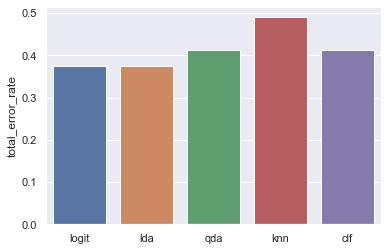

In [252]:
ax = sns.barplot(x=stats.index, y=stats['total_error_rate'])

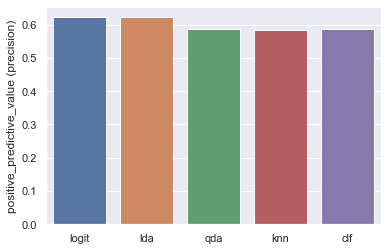

In [253]:
ax = sns.barplot(x=stats.index, y=stats['positive_predictive_value (precision)'])

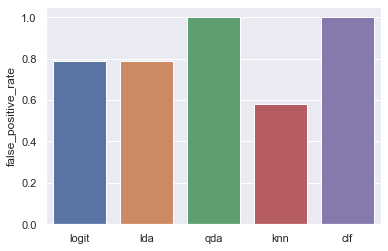

In [254]:
ax = sns.barplot(x=stats.index, y=stats['false_positive_rate'])

Logistic regression and LDA provide the best results in terms of oeverall error rate. That is, they make the lowest number of incorrect predictions overall. These models produce an total error rate of 37.5% which is better than the naive approach of assuming all results are positive which would yield 41.3% error rate. These models also exhibit the highest precision, that is a higher proportion of positive predictions are correct. 

With a total error rate of 50.9% KNN performs worse than a naive approach overall, but it is superior in terms of specificity. Therefore knn might be prefered if we wanted to minimise false positive predictions.

In terms of predicting which stocks to invest in, we are most concerned with the precision of our model, e.g. what proportion of stocks we invest in actually return dividends. Therefore LDA or Logistic Regression seem like the best choices.

### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [255]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

predictors  = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Year']
X_train = np.array(weekly_df_train[predictors])
X_test  = np.array(weekly_df_test[predictors])
y_train = np.array(weekly_df_train['Direction_Up'])
y_test  = np.array(weekly_df_test['Direction_Up'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)
# CLF
clf         = GaussianNB()
model_clf   = clf.fit(X_train, y_train)
# KNN_1
K = 1
model_knn_1 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
# KNN_3
K = 3
model_knn_3 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
# KNN_10
K = 10
model_knn_10 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda,
          'clf': model_clf,
          'knn_1': model_knn_1,
          'knn_3': model_knn_3,
          'knn_10': model_knn_10}
scaled = ['knn_1', 'knn_3', 'knn_10']


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



,y_pred=0,y_pred=1,Total
,,,
y=0,31,12,43
y=1,44,17,61
Total,75,29,


prior_error_rate                         0.413462
total_error_rate                         0.538462
true_positive_rate (sensitivity)         0.278689
false_negative_rate                      0.721311
false_positive_rate                      0.279070
true_negative_rate (specificity)         0.720930
positive_predictive_value (precision)    0.586207
negative_predictive_value                0.413333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,30,13,43
y=1,44,17,61
Total,74,30,


prior_error_rate                         0.413462
total_error_rate                         0.548077
true_positive_rate (sensitivity)         0.278689
false_negative_rate                      0.721311
false_positive_rate                      0.302326
true_negative_rate (specificity)         0.697674
positive_predictive_value (precision)    0.566667
negative_predictive_value                0.405405
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,38,5,43
y=1,50,11,61
Total,88,16,


prior_error_rate                         0.413462
total_error_rate                         0.528846
true_positive_rate (sensitivity)         0.180328
false_negative_rate                      0.819672
false_positive_rate                      0.116279
true_negative_rate (specificity)         0.883721
positive_predictive_value (precision)    0.687500
negative_predictive_value                0.431818
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,42,1,43
y=1,59,2,61
Total,101,3,


prior_error_rate                         0.413462
total_error_rate                         0.576923
true_positive_rate (sensitivity)         0.032787
false_negative_rate                      0.967213
false_positive_rate                      0.023256
true_negative_rate (specificity)         0.976744
positive_predictive_value (precision)    0.666667
negative_predictive_value                0.415842
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,18,25,43
y=1,22,39,61
Total,40,64,


prior_error_rate                         0.413462
total_error_rate                         0.451923
true_positive_rate (sensitivity)         0.639344
false_negative_rate                      0.360656
false_positive_rate                      0.581395
true_negative_rate (specificity)         0.418605
positive_predictive_value (precision)    0.609375
negative_predictive_value                0.450000
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,12,31,43
y=1,21,40,61
Total,33,71,


prior_error_rate                         0.413462
total_error_rate                         0.500000
true_positive_rate (sensitivity)         0.655738
false_negative_rate                      0.344262
false_positive_rate                      0.720930
true_negative_rate (specificity)         0.279070
positive_predictive_value (precision)    0.563380
negative_predictive_value                0.363636
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,21,22,43
y=1,25,36,61
Total,46,58,


prior_error_rate                         0.413462
total_error_rate                         0.451923
true_positive_rate (sensitivity)         0.590164
false_negative_rate                      0.409836
false_positive_rate                      0.511628
true_negative_rate (specificity)         0.488372
positive_predictive_value (precision)    0.620690
negative_predictive_value                0.456522
dtype: float64

## 14. 
In this problem, develop a model to predict whether a given car gets high or low gas mileage based on the 'Auto' data set.

### (a) Create a binary variable, 'mpg01', that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() function. Note you may find it helpful to use the data.frame() function to create a single data set containing both mpg01 and the other 'Auto' variables.

In [256]:
#Load the Auto data set as auto_df

auto_df = load_data("auto")
auto_df

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()

# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'],
             'qual': ['name']}

quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Add mpg01 feature
mpg01   = (auto_df['mpg'] > auto_df['mpg'].median()).astype(np.float64)
auto_df = pd.concat([auto_df, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto_df.head()

display(auto_df.head())

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0


### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.


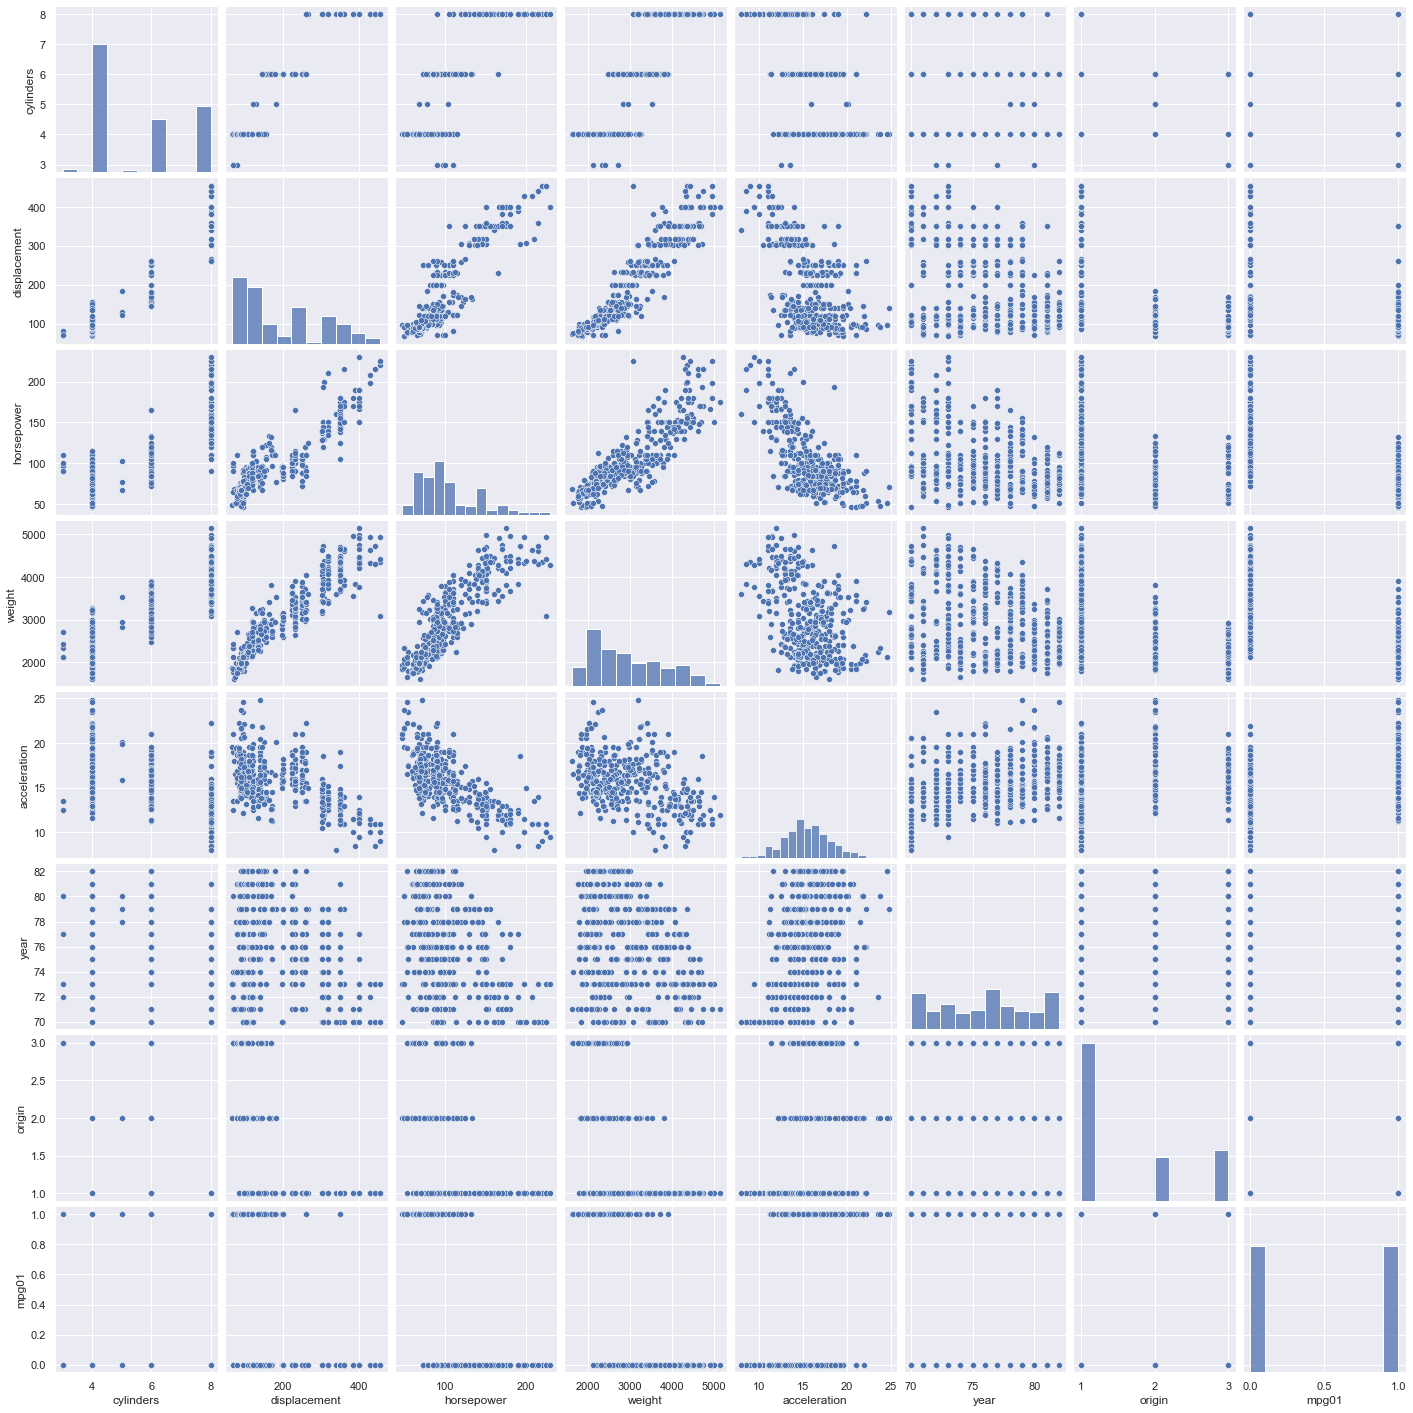

In [257]:
sns.pairplot(auto_df);

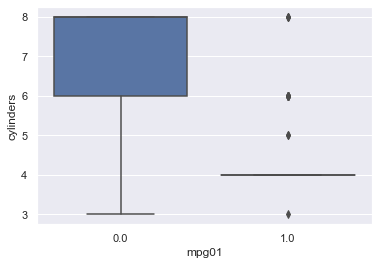

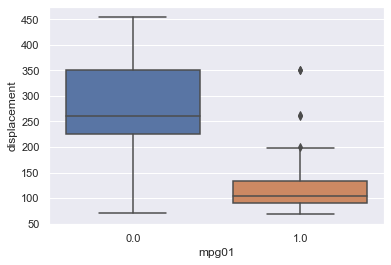

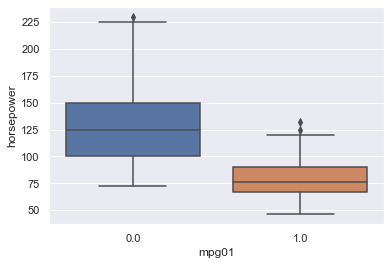

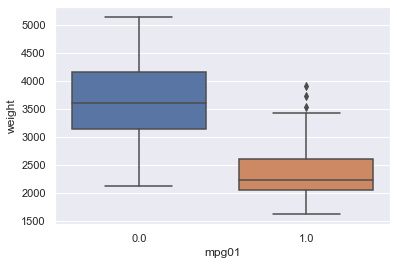

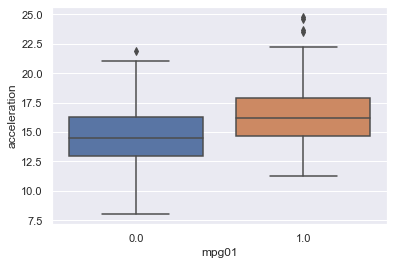

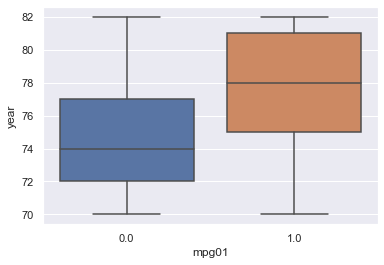

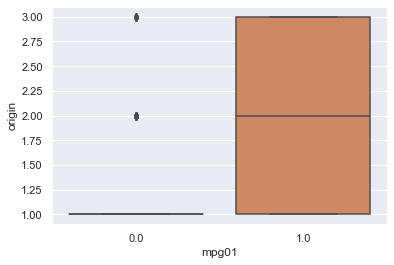

In [258]:
for c in auto_df.columns.drop(['mpg01', 'name']):
    sns.boxplot(x=auto_df['mpg01'], y=auto_df[c])
    plt.show();

Weight, displacement and cyclinders look like the most predictive features.

### (c) Split the data into a training set and a test set.

In [259]:
# Create index for training set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

# Training set (70%)
display(HTML('<h3>Training set</h3>'))
display(auto_df[train].head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(auto_df[~train].head())


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0
5,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500,0.0


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),0.0
20,4.0,110.0,87.0,2672.0,17.5,70.0,2.0,peugeot 504,1.0
21,4.0,107.0,90.0,2430.0,14.5,70.0,2.0,audi 100 ls,1.0
24,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin,0.0


In [260]:
# Create index for training set
np.random.seed(1)
train_idx = np.random.rand(len(auto_df)) < 0.7
auto_df_train = auto_df[train_idx]
auto_df_test  = auto_df[~train_idx]

### (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b).  What is the test error of the model obtained?

In [261]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)
# CLF
clf         = GaussianNB()
model_clf   = clf.fit(X_train, y_train)

models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda,
          'clf': model_clf}
scaled = []


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,4,50,54
Total,60,60,


prior_error_rate                         0.550000
total_error_rate                         0.116667
true_positive_rate (sensitivity)         0.925926
false_negative_rate                      0.074074
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.833333
negative_predictive_value                0.933333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,2,52,54
Total,58,62,


prior_error_rate                         0.550000
total_error_rate                         0.100000
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.838710
negative_predictive_value                0.965517
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


prior_error_rate                         0.550000
total_error_rate                         0.091667
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.136364
true_negative_rate (specificity)         0.863636
positive_predictive_value (precision)    0.852459
negative_predictive_value                0.966102
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,4,50,54
Total,61,59,


prior_error_rate                         0.550000
total_error_rate                         0.108333
true_positive_rate (sensitivity)         0.925926
false_negative_rate                      0.074074
false_positive_rate                      0.136364
true_negative_rate (specificity)         0.863636
positive_predictive_value (precision)    0.847458
negative_predictive_value                0.934426
dtype: float64

**Comment**

After some experimentation with features, I achieved the lowest total error rates with with 'weight', 'cylinders', 'year', 'acceleration'.

Without acceleration linear models were superior. Adding acceleration had no effect on linear models but improved qda suggesting that the addition of acceleration adds a non-linear relationship which linear models are unable to represent.

The QDA result can be achieved with LDA by taking log of predictors.

### (h) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?



In [262]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
    # Predict
    y_pred = model.predict(preprocessing.scale(X_test))
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,62,4,66
y=1,7,47,54
Total,69,51,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


**Comment**

- KNN beats QDA with a total error rate of 7.5% for K = {1, 3, 5, 7, 8} and a slightly lower false positive rate
- the confusion matrix is identical for all top performing K values
- the same predictors appear to work best for KNN as for parametric techniques

## 16. 
Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [263]:
boston = load_data("boston")
boston

# Check for missing values
assert boston.isnull().sum().sum() == 0

# Add "crime is above median" logistic response
crim01 = (boston['crim'] > boston['crim'].median()).astype(np.float64).rename('crim01')
boston_df = pd.concat([boston, crim01], axis=1).drop('crim', axis=1)

# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

boston_df[train].head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim01
0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0.0
2,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,0.0
3,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,0.0
4,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,0.0
5,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7,0.0


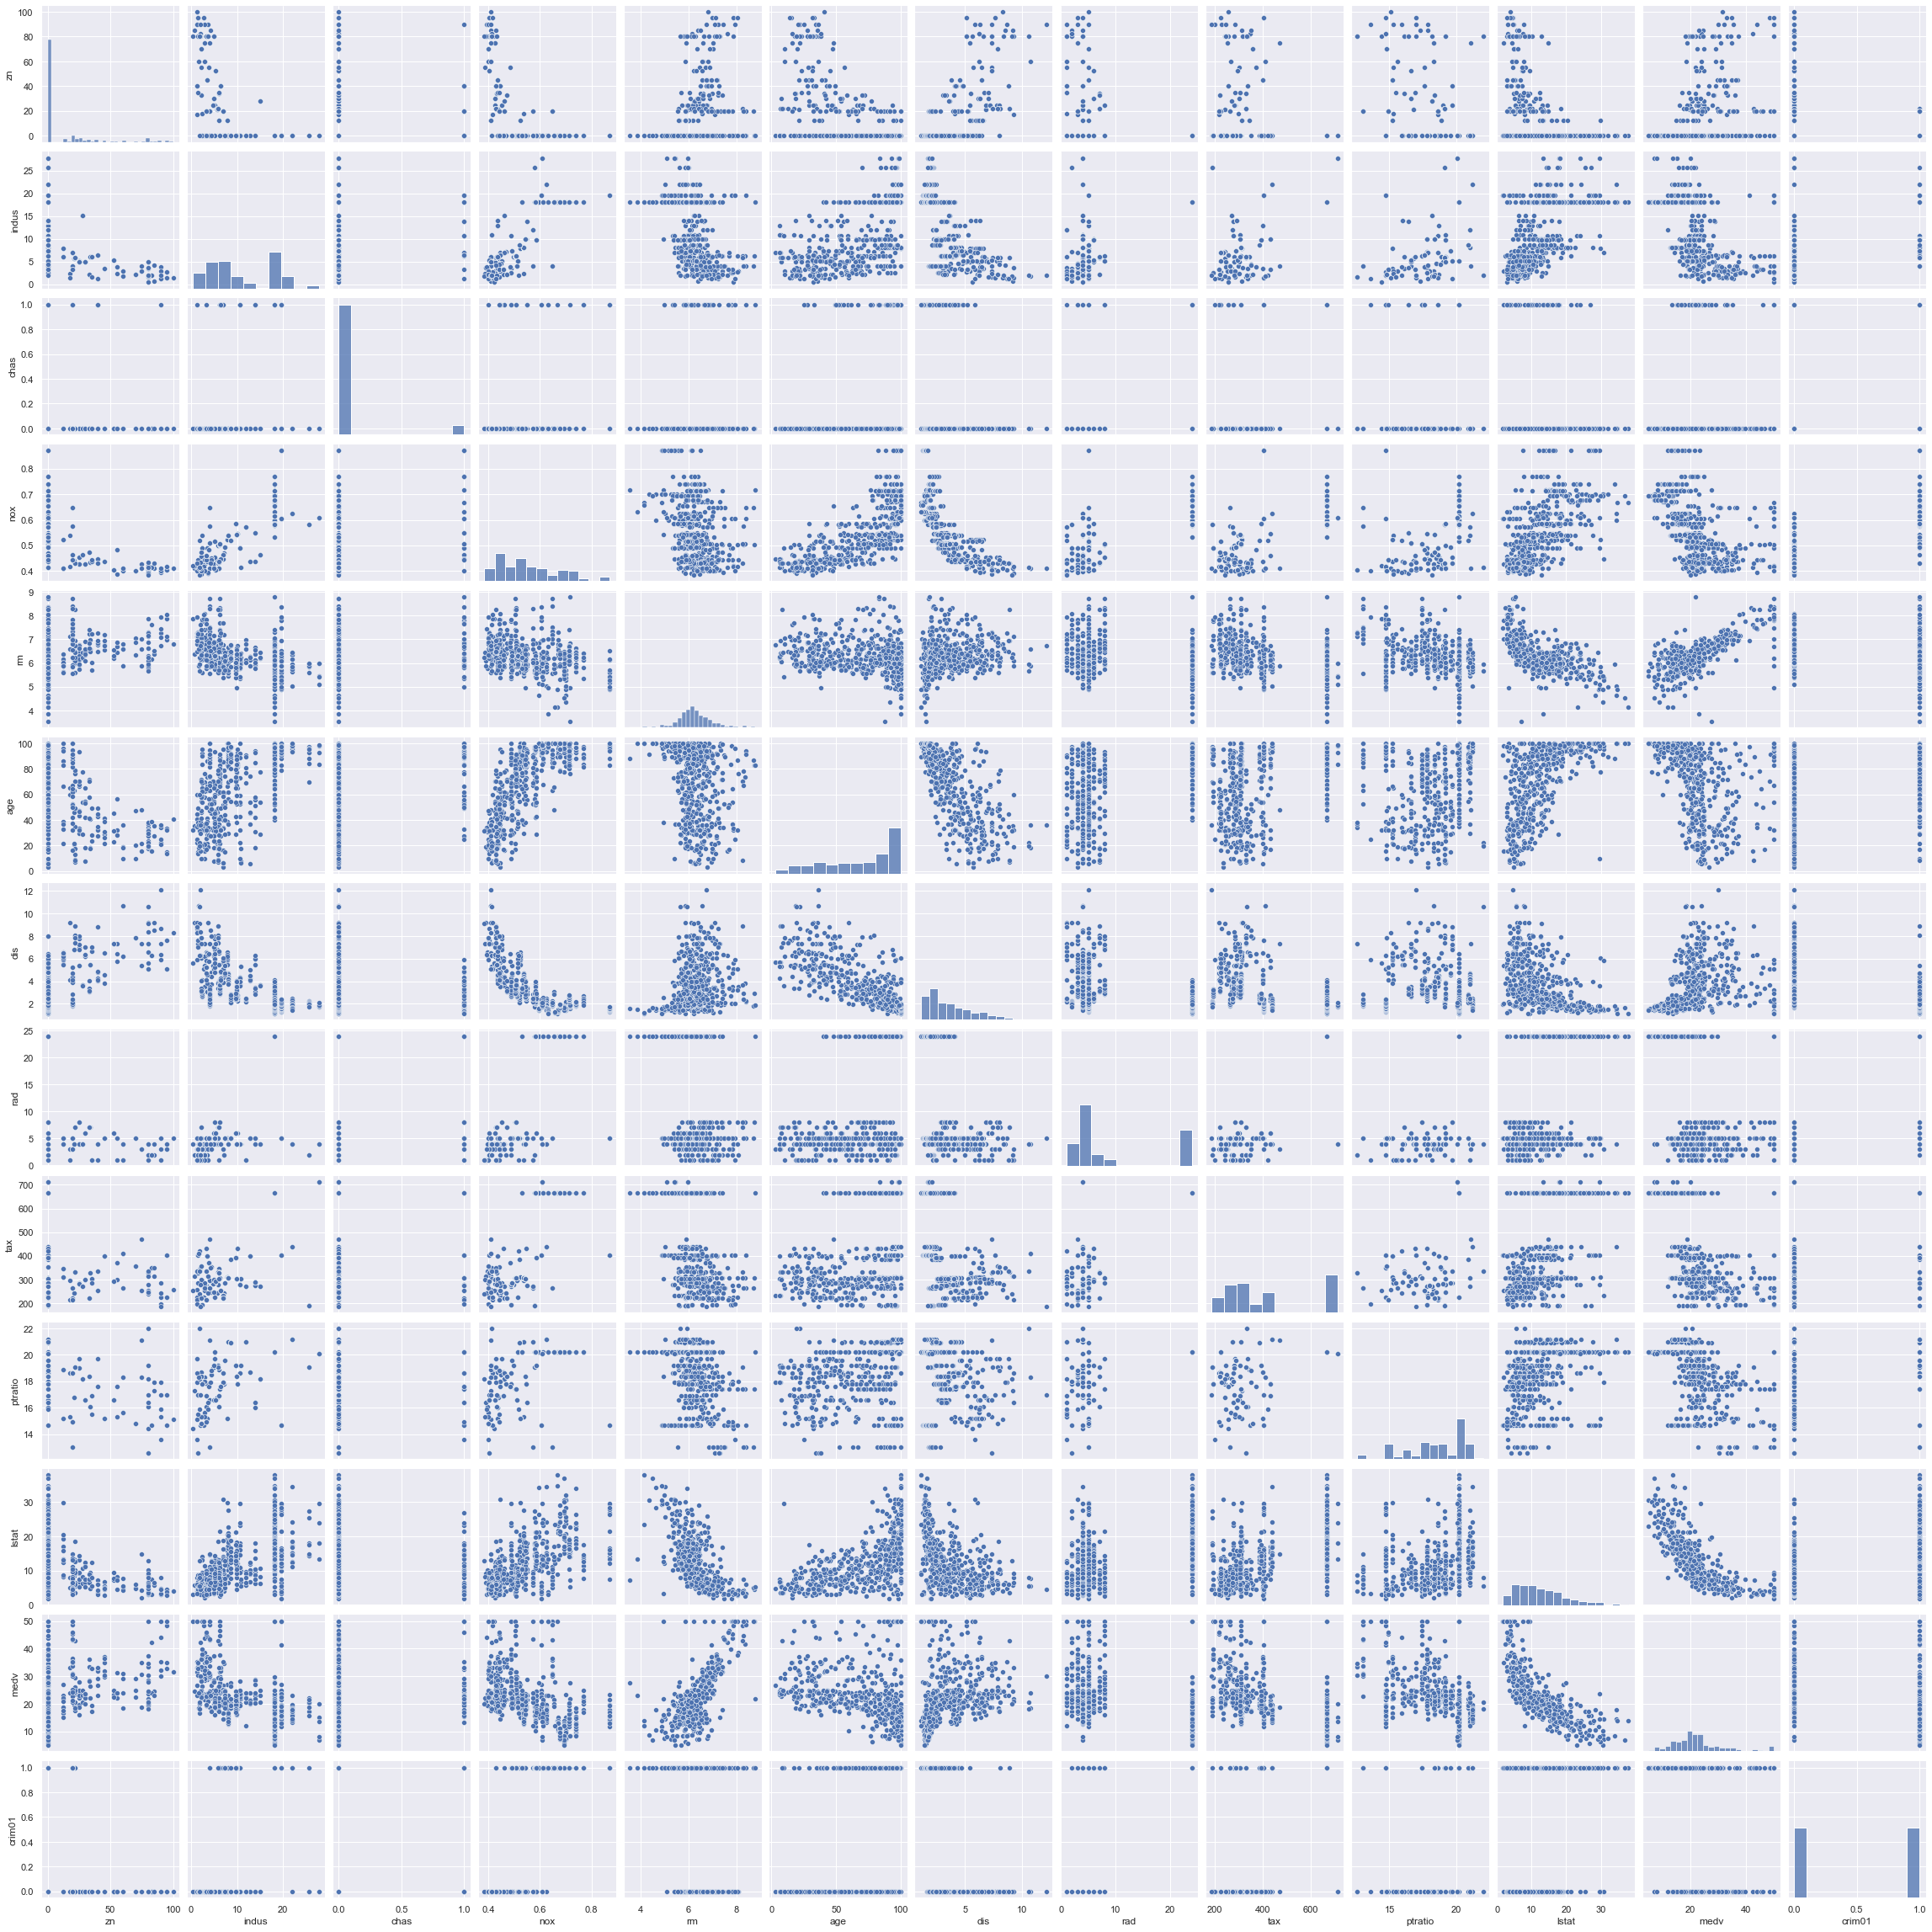

In [264]:
sns.pairplot(boston_df);

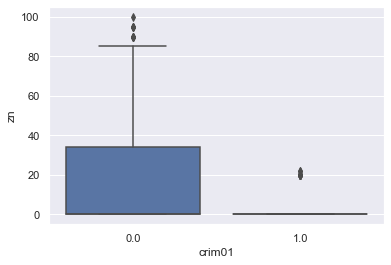

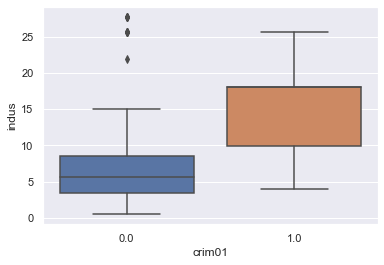

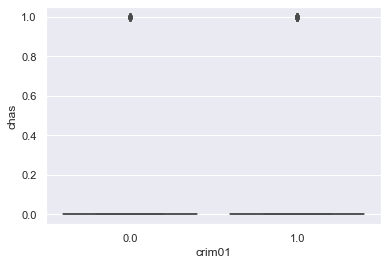

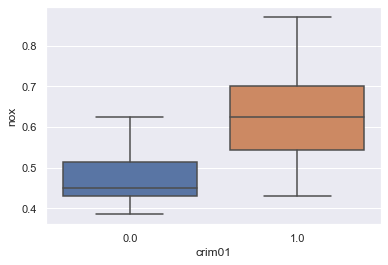

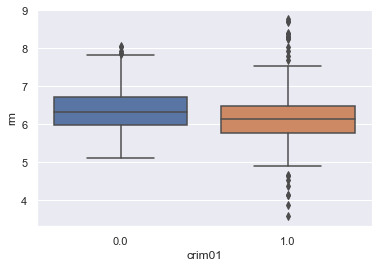

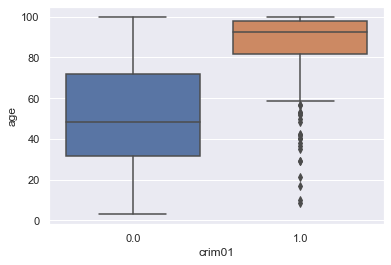

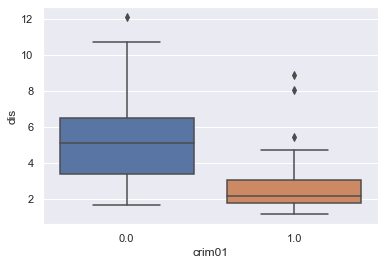

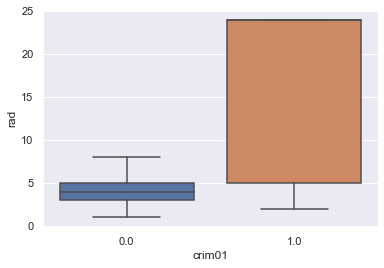

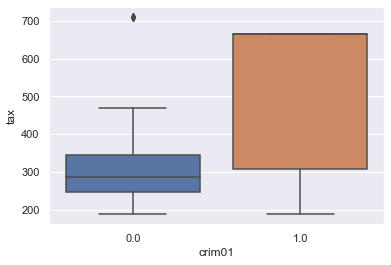

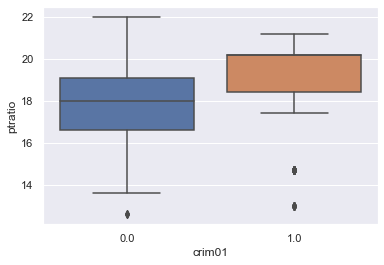

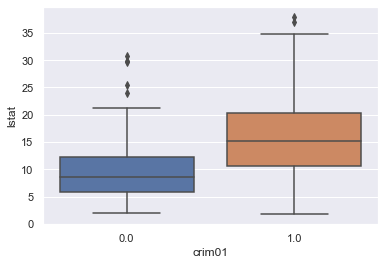

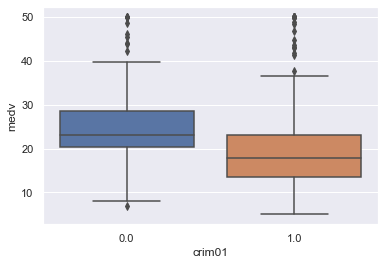

In [265]:
for c in boston_df.columns.drop(['crim01']):
    sns.boxplot(x=boston_df['crim01'], y=boston_df[c])
    plt.show();

In [266]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

response   = 'crim01'
predictors = ['nox', 'rm', 'dis', 'rad', 'lstat', 'zn', 'tax', 'indus', 'ptratio']


X_train = np.array(boston_df[train][predictors])
X_test  = np.array(boston_df[~train][predictors])
y_train = np.array(boston_df[train][response])
y_test  = np.array(boston_df[~train][response])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)
# CLF
clf         = GaussianNB()
model_clf   = clf.fit(X_train, y_train) 

models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda,
          'clf': model_clf}

# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))

C:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,y_pred=0,y_pred=1,Total
,,,
y=0,63,12,75
y=1,16,66,82
Total,79,78,


prior_error_rate                         0.477707
total_error_rate                         0.178344
true_positive_rate (sensitivity)         0.804878
false_negative_rate                      0.195122
false_positive_rate                      0.160000
true_negative_rate (specificity)         0.840000
positive_predictive_value (precision)    0.846154
negative_predictive_value                0.797468
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,21,61,82
Total,93,64,


prior_error_rate                         0.477707
total_error_rate                         0.152866
true_positive_rate (sensitivity)         0.743902
false_negative_rate                      0.256098
false_positive_rate                      0.040000
true_negative_rate (specificity)         0.960000
positive_predictive_value (precision)    0.953125
negative_predictive_value                0.774194
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,5,77,82
Total,79,78,


prior_error_rate                         0.477707
total_error_rate                         0.038217
true_positive_rate (sensitivity)         0.939024
false_negative_rate                      0.060976
false_positive_rate                      0.013333
true_negative_rate (specificity)         0.986667
positive_predictive_value (precision)    0.987179
negative_predictive_value                0.936709
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,64,11,75
y=1,21,61,82
Total,85,72,


prior_error_rate                         0.477707
total_error_rate                         0.203822
true_positive_rate (sensitivity)         0.743902
false_negative_rate                      0.256098
false_positive_rate                      0.146667
true_negative_rate (specificity)         0.853333
positive_predictive_value (precision)    0.847222
negative_predictive_value                0.752941
dtype: float64

**Comment**

- QDA yields an total error of 3.82%. Far superior to Logistic, LDA and naive Bayes. This is not suprising given the non-linear relationships apparent in the pairwise plots above.
- Feature scaling, and log transforms both increased the error rate. 
- To achive the above results I started with the 'NOX' feature which appeared strongest in plots, then iteratively tried adding an additional feature – I chose the feature that yielded the greatest reduction in total_error_rate. I repeated this process to choose the next feature and so on.


In [267]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

response   = 'crim01'
predictors = ['nox', 'rm', 'dis', 'rad', 'lstat', 'zn', 'tax', 'indus', 'ptratio']

X_train = preprocessing.scale(np.array(boston_df[train][predictors]))
X_test  = preprocessing.scale(np.array(boston_df[~train][predictors]))
y_train = np.array(boston_df[train][response])
y_test  = np.array(boston_df[~train][response])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,7,75,82
Total,80,77,


total_error_rate: 
0.0573248407643312


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,10,72,82
Total,84,73,


total_error_rate: 
0.07006369426751591


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,9,73,82
Total,83,74,


total_error_rate: 
0.06369426751592355


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,10,72,82
Total,84,73,


total_error_rate: 
0.07006369426751591


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,8,74,82
Total,81,76,


total_error_rate: 
0.06369426751592355


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,11,71,82
Total,85,72,


total_error_rate: 
0.07643312101910826


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,10,72,82
Total,81,76,


total_error_rate: 
0.08917197452229297


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,12,70,82
Total,85,72,


total_error_rate: 
0.08917197452229297


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,10,72,82
Total,83,74,


total_error_rate: 
0.07643312101910826


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,14,68,82
Total,87,70,


total_error_rate: 
0.10191082802547768


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,13,69,82
Total,84,73,


total_error_rate: 
0.10828025477707004


,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,15,67,82
Total,87,70,


total_error_rate: 
0.1146496815286624


,y_pred=0,y_pred=1,Total
,,,
y=0,68,7,75
y=1,14,68,82
Total,82,75,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,69,6,75
y=1,15,67,82
Total,84,73,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,68,7,75
y=1,14,68,82
Total,82,75,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,19,63,82
Total,90,67,


total_error_rate: 
0.14649681528662417


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,17,65,82
Total,88,69,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,20,62,82
Total,93,64,


total_error_rate: 
0.14012738853503182


,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,20,62,82
Total,92,65,


total_error_rate: 
0.14649681528662417


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,21,61,82
Total,94,63,


total_error_rate: 
0.14649681528662417


**Comment**

- K=1 is the strongest KNN model with total error of 5.73%, but it is inferior to QDA at 3.82%
- The optimal features for QDA also seem to be optimal for KNN
- scaling: Suprisingly, mean removal and variance scaling does not improve results. Scaling to (0,1) range worsens results
- transform: log1p transform of features worsens results
